# ECE 447: Multi-input / Multi-output

Eric Klavins|

Copyright &copy; University of Washington, 2019

# Code

In [117]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sympy import *
from matplotlib import animation

# Uncomment on Google colab
# !pip install JSAnimation
# !pip install control

from JSAnimation.IPython_display import display_animation
from control import * 

%matplotlib inline

# Comment out in Google colab 
init_printing(use_latex='mathjax')

# Uncomment in below Google colab to render sympy equations nicely
# def custom_latex_printer(exp,**options):
#     from google.colab.output._publish import javascript
#     url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
#     javascript(url=url)
#     return printing.latex(exp,**options)

# MIMO for Transfer Functions

In MIMO systems, transfer functions are arranged into matrices. You can't avoid linear algebra!

Example
---

As an example, suppose we have the following system

<img width=75% src="https://raw.githubusercontent.com/klavins/ECE447/master/images/mimo-tf.png" style="transform: rotate(2deg)">

By following the wires, we can write down relationships betweens the inputs, outputs, and blocks. For the first output:

\begin{align}
Y_1 & = G_1 G_2 U_1 + G_4 ( G_1 U_1 + G_3 U_2 ) \\
    & = ( G_1 G_2 + G_1 G_4 ) U_1 + G_3 G_4 U_2
\end{align}

And for the second output:

\begin{align}
Y_2 & = G_4 ( G_1 U_1 + G_3 U_2 ) \\
    & = G_1 G_4 U_1 + G_3 G_4 U_2 
\end{align}

Systems of linear equations are always more convenient in matrix form:

\begin{align}
{\bf Y}(s) & = \begin{pmatrix}
G_1(s) G_2(s) + G_1(s) G_4(s) & G_3(s) G_4(s) \\
G_1(s) G_4(s) & G_3(s) G_4(s) 
\end{pmatrix} {\bf U}(s) \\
 & = {\bf T}(s) {\bf U}(s)
\end{align}

The only thing you can't do is write $Y(s) / U(s)$ for vectors of transfer functions. 

Composition
---

Compositions go through as usual, as long as the size of the matrices are compatible.

**Series:**

<img width=65% src="https://raw.githubusercontent.com/klavins/ECE447/master/images/mimo-series.png">

- $G_1$ is $m \times n$
- $G_2$ is $p \times m$
- $G_1 G_2$ is $p \times n$

Note that the composition $G_1 G_2$ is just matrix multiplication.

**Feedback:**

<img width=55% src="https://raw.githubusercontent.com/klavins/ECE447/master/images/mimo-fb.png">

In the feedback case, we have

$$
Y = GE = G(U-Y) = GU-GY
$$

Therefore, 

\begin{align}
Y+GY & = GU \\
(I+G)Y & = GU \\ 
Y & = (I+G)^{-1}GU
\end{align}

Assuming $I+G$ is invertible.

# MIMO in State Space

In state space, MIMO is very natural and requires essentially no new notation. You just have to make sure the dimensions line up.

<img width=70% src="https://raw.githubusercontent.com/klavins/ECE447/master/images/mino-ss1.png">

The transfer function is a matrix (as we showed above):

<img width=65% src="https://raw.githubusercontent.com/klavins/ECE447/master/images/mimo-ss2.png">

# The Observer as MIMO

The observer we designed in the previous notebook takes $y$ and $u$ as inputs and outputs $\hat{\x}$. Thus it is a two input, $n$ output system. 

Before we talked about MIMO, we denoted the observer by:

\begin{align}
\dot{\hat{\x}} & = A \hat{\x} + B u + L(y - \hat{y}) \\
\hat{y} & = C \hat{\x}
\end{align}

Now we can write

\begin{align}
\dot{\hat{\x}} & = (A-LC) \hat{\x} + \begin{pmatrix}
B & L 
\end{pmatrix} \begin{pmatrix}
u \\
y
\end{pmatrix}\\
\hat{y} & = C \hat{\x}
\end{align}

# Full State Feedback with an Observer

As a reminder, full state feedback requires the state of a linear system, which is not always available. But with an observer, you can supply the estimate of the full state to the control. Thus, we have the equations:

\begin{align}
\dot{\x} & = A \x + B u \\
y & = C \x \\
 \\
\dot{\hat{\x}} & = A \hat{\x} + B u + L(y - \hat{y}) \\
\hat{y} & = C \hat{\x} \\
 \\
u & = -K \hat{\x} + r
\end{align}

Remembering that $y = C\x$ and $\hat{y} = C \hat{\x}$ we get

\begin{align}
\begin{pmatrix}
\dot{\x} \\
\dot{\hat{\x}}
\end{pmatrix} & = 
\begin{pmatrix}
A & -BK \\
LC & A - BK - LC
\end{pmatrix} \begin{pmatrix}
\x \\
\hat{\x}
\end{pmatrix} + \begin{pmatrix}
B \\
B
\end{pmatrix} r \\
y & = ( \; C \;  0 \; ) \; \begin{pmatrix}
\x \\
\hat{\x}
\end{pmatrix}
\end{align}

So a system combing an observer and full state feedback is just another linear system. However, it is not clear that this new system is stable or what its eigenvalues are, and so on.

Let's define

$$
\tilde A \triangleq \begin{pmatrix}
A & -BK \\
LC & A - BK - LC
\end{pmatrix} 
$$.

**Property 1: Eigenvalues of $A-BK$ are also eigenvalues of $\tilde A$**:

Suppose $(A-BK) {\bf v} = \lambda {\bf v}$. Then

\begin{align}
\begin{pmatrix}
A & -BK \\
LC & A - BK - LC
\end{pmatrix} \begin{pmatrix}
{\bf v} \\
{\bf v}
\end{pmatrix} & = \begin{pmatrix}
A{\bf v} - BK{\bf v} \\
LC{\bf v} - (A - BK - LC) {\bf v} \\
\end{pmatrix} \\
& = \begin{pmatrix}
(A - BK){\bf v} \\
(A - BK){\bf v}
\end{pmatrix}  \\
& = \lambda \begin{pmatrix}
{\bf v} \\
{\bf v}
\end{pmatrix} .
\end{align}

**Property 2: Eigenvalues of $A-LC$ are also eigenvalues of $\tilde A$**:

Suppose $w^T(A-LC) = \rho w^T$. In this case, $w$ is a *left eigenvector* and $\rho$ is an plain eigenvalue. Then

\begin{align}
\begin{pmatrix}
w^T & - w^T
\end{pmatrix} \begin{pmatrix}
A & -BK \\
LC & A - BK - LC
\end{pmatrix} & = \begin{pmatrix}
w^T(A-LC) &  w^T(A-LC) 
\end{pmatrix}  \\
 & = \rho \begin{pmatrix}
w^T & - w^T
\end{pmatrix} . 
\end{align}

**The Point:** You can design $K$ and $L$ completely separately, using $K$ to set $n$ of the poles of the entire system, and $L$ to design the other $n$ poles.

Example
---

In [137]:
A = Matrix([
    [0,-1,0],
    [3,0,-72],
    [0,0.5,-30]])

B = Matrix([
    [0],
    [0],
    [1]
])

C = Matrix([[1,0,0]])

An = np.array(A).astype(np.float64)
Bn = np.array(B).astype(np.float64)
Cn = np.array(C).astype(np.float64)

K = Matrix(place(An,Bn,[-1,-1+1*1j,-1-4*1j]))

L = Matrix(np.transpose(
        place(np.transpose(An),np.transpose(Cn), [-10,-11,-12]))
    )
N(K,2),N(L,2)

⎛[0.069  0.21  -25.0], ⎡  3.0  ⎤⎞
⎜                      ⎢       ⎥⎟
⎜                      ⎢-2.3e+2⎥⎟
⎜                      ⎢       ⎥⎟
⎝                      ⎣ -82.0 ⎦⎠

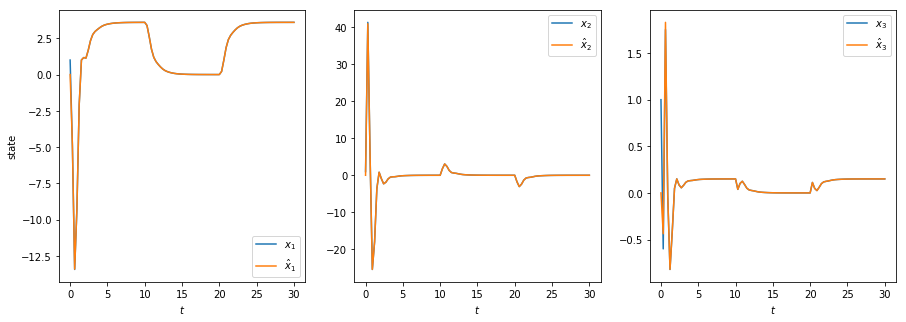

In [138]:
def input(t):
    if t < 10:
        return 1
    elif t < 20:
        return 0
    else:
        return 1
    
def f(X,t):
    x = X[:3]
    xhat = X[3:6]
    u = -(K*Matrix(xhat))[0] + input(t)
    fb = L * ( C*x - C*xhat )
    return flatten(
        (A*Matrix(x) + B*u).tolist() + 
        (A*Matrix(xhat) + B*u + fb).tolist())

t=np.linspace(0,30,100)
X = spi.odeint(f,[1,1,1,0,0,0],t)
fig,ax = plt.subplots(1,3,figsize=(15,5))

for i in range(3):
    ax[i].plot(t,X[:,i],label="$x_%d$" % (i+1))
    ax[i].plot(t,X[:,3+i],label="$\hat{x}_%d$" % (i+1));
    ax[i].set_xlabel("$t$")
    ax[i].legend()
    
ax[0].set_ylabel("state");

In [135]:
# Check the eigenvalues
top = Matrix([A.transpose(), -(B*K).transpose()]).transpose()
bot = Matrix([(L*C).transpose(), (A-B*K-L*C).transpose()]).transpose()
Atilde = Matrix([top,bot])
N(Atilde,2)

⎡   0     -1.0    0       0       0      0  ⎤
⎢                                           ⎥
⎢  3.0     0    -72.0     0       0      0  ⎥
⎢                                           ⎥
⎢   0     0.5   -30.0  -0.069   -0.21  25.0 ⎥
⎢                                           ⎥
⎢1.2e+2    0      0    -1.2e+2  -1.0     0  ⎥
⎢                                           ⎥
⎢-3.8e+3   0      0    3.8e+3     0    -72.0⎥
⎢                                           ⎥
⎣ 38.0     0      0     -38.0   0.29   -5.0 ⎦

In [136]:
e,v = np.linalg.eig(np.array(Atilde.tolist()).astype(np.float64));
e

array([-60.+0.j, -50.+0.j, -40.+0.j,  -2.+4.j,  -2.-4.j,  -1.+0.j])